In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp '/content/drive/My Drive/CapstoneAIML/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#https://www.kaggle.com/questions-and-answers/165032#1327573
from kaggle.api.kaggle_api_extended import KaggleApi
DS_PATH = "/content/dataset"
COMPETITION = "rsna-pneumonia-detection-challenge"
api = KaggleApi()
api.authenticate()
api.competition_download_files(COMPETITION, DS_PATH)

In [ ]:
!  unzip -oq /content/dataset/rsna-pneumonia-detection-challenge.zip -d /content/dataset

In [ ]:
!ls -l /content/dataset

total 3845400
-rw-r--r-- 1 root root         55 Dec 11  2019 'GCP Credits Request Link - RSNA.txt'
-rw-r--r-- 1 root root 3932287530 Mar 25 10:18  rsna-pneumonia-detection-challenge.zip
-rw-r--r-- 1 root root    1647396 Dec 11  2019  stage_2_detailed_class_info.csv
-rw-r--r-- 1 root root     159027 Dec 11  2019  stage_2_sample_submission.csv
drwxr-xr-x 2 root root     221184 Mar 25 10:19  stage_2_test_images
drwxr-xr-x 2 root root    1867776 Mar 25 10:19  stage_2_train_images
-rw-r--r-- 1 root root    1490034 Dec 11  2019  stage_2_train_labels.csv


### Necessary library imports 

In [ ]:
import os
import cv2
import glob
import time

! pip install pydicom
import pydicom

import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import feature, filters
%matplotlib inline

from functools import partial
from collections import defaultdict
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')



     |████████████████████████████████| 2.0 MB 7.8 MB/s 


In [ ]:
# List our paths
trainImagesPath = "/content/dataset/stage_2_train_images"
testImagesPath = "/content/dataset/stage_2_test_images"

labelsPath = "/content/dataset/stage_2_train_labels.csv"
classInfoPath = "/content/dataset/stage_2_detailed_class_info.csv"

# Read the labels and classinfo
labels = pd.read_csv(labelsPath)
details = pd.read_csv(classInfoPath)

## Part 3.1: Attaining our Training & Testing Data in Proper Format

In [ ]:
"""
@Description: Reads an array of dicom image paths, and returns an array of the images after they have been read

@Inputs: An array of filepaths for the images

@Output: Returns an array of the images after they have been read
"""
def readDicomData(data):
    
    res = []
    
    for filePath in tqdm(data): # Loop over data
        
        # We use stop_before_pixels to avoid reading the image (Saves on speed/memory)
        f = pydicom.read_file(filePath, stop_before_pixels=True)
        res.append(f)
    
    return res

In [ ]:
# Get an array of the test & training file paths
trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

# Read data into an array
trainImages = readDicomData(trainFilepaths[:5000])
testImages = readDicomData(testFilepaths)

100%|██████████| 3000/3000 [00:03<00:00, 832.67it/s]


## Part 3.2: Balancing our Data
We balance our data as CNNs work best on evenly balanced data



In [ ]:
COUNT_NORMAL = len(labels.loc[labels['Target'] == 0]) # Number of patients with no pneumonia
COUNT_PNE = len(labels.loc[labels['Target'] == 1]) # Number of patients with pneumonia
TRAIN_IMG_COUNT = len(trainFilepaths) # Total patients

# We calculate the weight of each
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNE)*(TRAIN_IMG_COUNT)/2.0

classWeight = {0: weight_for_0, 
               1: weight_for_1}

print(f"Weights: {classWeight}")

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


## Part 3.3: Get Train_Y & Test_Y

In [ ]:
"""
@Description: This function parses the medical images meta-data contained

@Inputs: Takes in the dicom image after it has been read

@Output: Returns the unpacked data and the group elements keywords
"""
def parseMetadata(dcm):
    
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm: # Iterate here to force conversion from lazy RawDataElement to DataElement
        pass
    
    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords

In [ ]:
# These parse the metadata into dictionaries
trainMetaDicts, trainKeyword = zip(*[parseMetadata(x) for x in tqdm(trainImages)])
testMetaDicts, testKeyword = zip(*[parseMetadata(x) for x in tqdm(testImages)])

100%|██████████| 3000/3000 [00:02<00:00, 1097.71it/s]


In [ ]:
"""
@Description: This function goes through the dicom image information and returns 1 or 0
              depending on whether the image contains Pneumonia or not

@Inputs: A dataframe containing the metadata

@Output: Returns the Y result (i.e: our train and test y)
"""
def createY(df):
    y = (df['SeriesDescription'] == 'view: PA')
    Y = np.zeros(len(y)) # Initialise Y
    
    for i in range(len(y)):
        if(y[i] == True):
            Y[i] = 1
    
    return Y


train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

df = train_df
df2 = test_df

train_Y = createY(df) # Create training Y 
test_Y = createY(df2) # Create testing Y



## Part 3.4: Get Train_X & Test_X

In [ ]:
"""
@Description: This decodes an image by reading the pixel array, resizing it into the correct format and
              normalising the pixels

@Inputs:
    - filePath: This is the filepath of the image that we want to decode

@Output:
    - img: This is the image after it has been decoded
"""
def decodeImage(filePath):
    image = pydicom.read_file(filePath).pixel_array
    image = cv2.resize(image, (128, 128))
    return (image/255)

In [ ]:
# Get our train x in the correct shape
train_X = []

for filePath in tqdm(trainFilepaths[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)

train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [00:40<00:00, 123.19it/s]


In [ ]:
# Get our test x in the correct shape for NN
test_X = []

for filePath in tqdm(testFilepaths):
    img_test = decodeImage(filePath) # Decode & Resize
    test_X.append(img_test)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 3000/3000 [00:23<00:00, 125.54it/s]


In [ ]:
"""
@Description: This function plots our metrics for our models across epochs

@Inputs: The history of the fitted model

@Output: N/A
"""
def plottingScores(hist):
    fig, ax = plt.subplots(1, 5, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

## Part 3.5: Metrics Evaluation

For our metrics, we want to include precision and recall as they will provide use with more info on how good our model is



*   Accuracy: This tells us what fraction of the labels are correct.
    *   Since our data is not balanced, accuracy might give a skewed sense of a good model
*   Precision: This tells us the number of true positives (TP) over the sum of TP and false positives (FP).
    *   It shows what fraction of labeled positives are actually correct.
*   Recall: The number of TP over the sum of TP and false negatves (FN).
    *   It shows what fraction of actual positives are correct.










In [ ]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

####  Tuning our Models with Callbacks

*   We'll use Keras callbacks to further finetune our model.
*   The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it.
*   The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting.
*   Since we set restore_best_weights to True, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [ ]:
# Define our callback functions to pass when fitting our NNs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

## Part 3.6: Building Model #1 - Fully Connected Model

In [ ]:
"""
@Description: This function builds our simple Fully-connected NN

@Inputs: N/A

@Output: Returns the FCNN Model
"""
def build_fcnn_model():
    
    # Basic model with a flattening layer followng by 2 dense layers
    # The first dense layer is using relu and the 2nd one is using sigmoid
    model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape = (128, 128, 3)), 
                tf.keras.layers.Dense(128, activation = "relu"), 
                tf.keras.layers.Dense(1, activation = "sigmoid")
                ])
    
    return model

In [ ]:
# Build our FCNN model and compile
model_fcnn = build_fcnn_model()
model_fcnn.summary()
model_fcnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS) # Compile

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6291584   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________


### Fitting Model to Training Data

In [ ]:
history_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 30,
                          batch_size = 128,
                          validation_split = 0.2, 
                          class_weight = classWeight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit the model

Epoch 1/30
32/32 [==============================] - 2s 42ms/step - loss: 43.7029 - accuracy: 0.6018 - precision: 0.6127 - recall: 0.7634 - AUC: 0.5876 - val_loss: 9.3675 - val_accuracy: 0.6470 - val_precision: 0.6099 - val_recall: 0.9872 - val_AUC: 0.6360 - lr: 0.0100
Epoch 2/30
32/32 [==============================] - 1s 31ms/step - loss: 3.1240 - accuracy: 0.7770 - precision: 0.7567 - recall: 0.8804 - AUC: 0.7956 - val_loss: 2.8927 - val_accuracy: 0.7780 - val_precision: 0.7270 - val_recall: 0.9526 - val_AUC: 0.8196 - lr: 0.0089
Epoch 3/30
32/32 [==============================] - 1s 22ms/step - loss: 1.2021 - accuracy: 0.8450 - precision: 0.8217 - recall: 0.9196 - AUC: 0.8836 - val_loss: 1.4978 - val_accuracy: 0.8110 - val_precision: 0.7561 - val_recall: 0.9672 - val_AUC: 0.8683 - lr: 0.0079
Epoch 4/30
32/32 [==============================] - 1s 17ms/step - loss: 0.5910 - accuracy: 0.8683 - precision: 0.8493 - recall: 0.9264 - AUC: 0.9227 - val_loss: 2.2350 - val_accuracy: 0.6680 - v

94/94 [==============================] - 1s 8ms/step - loss: 0.2695 - accuracy: 0.9043 - precision: 0.8675 - recall: 0.9710 - AUC: 0.9717
{'loss': 0.26948249340057373, 'accuracy': 0.9043333530426025, 'precision': 0.8674765229225159, 'recall': 0.9709517955780029, 'AUC': 0.9716918468475342}


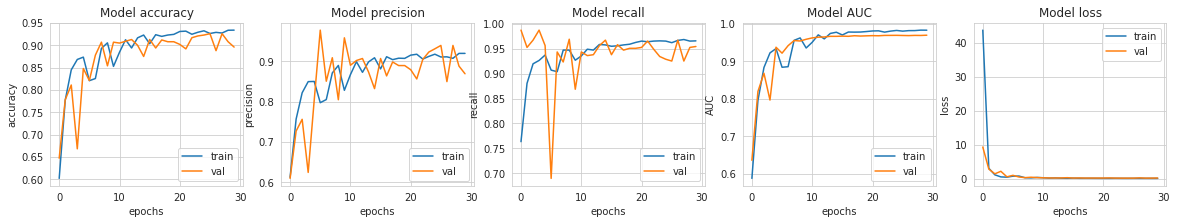

In [ ]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plottingScores(history_fcnn) # Visualise scores

## Part 3.7: Building Model #2 - CNN
In our CNN model, fewer parameters are needed because every convolutional layer reduces the dimensions of the input through the convolution operation.

In [ ]:
"""
@Description: This function builds our custom CNN Model

@Inputs: N/A

@Output: Returns the CNN model
"""
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu', input_shape=(128, 128, 3)), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu'), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(), # flatten output of conv
        tf.keras.layers.Dense(512, activation = "relu"), # hidden layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation = "relu"), #  output layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")])
    
    return model

In [ ]:
# Build and compile model
model_cnn = build_cnn_model()
model_cnn.summary()
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)       

In [ ]:
# Fit model
history_cnn = model_cnn.fit(train_X_rgb, 
                      train_Y,  
                      epochs=30, 
                      validation_split = 0.15, 
                      batch_size=128,
                      class_weight=classWeight,
                      callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
                      verbose=1) # Fit the model

Epoch 1/30
34/34 [==============================] - 12s 76ms/step - loss: 0.4073 - accuracy: 0.8261 - precision: 0.8381 - recall: 0.9192 - AUC: 0.9368 - val_loss: 114.4706 - val_accuracy: 0.5467 - val_precision: 0.5467 - val_recall: 1.0000 - val_AUC: 0.5000 - lr: 0.0100
Epoch 2/30
34/34 [==============================] - 1s 44ms/step - loss: 0.2272 - accuracy: 0.8951 - precision: 0.8782 - recall: 0.9409 - AUC: 0.9638 - val_loss: 26.6442 - val_accuracy: 0.5467 - val_precision: 0.5467 - val_recall: 1.0000 - val_AUC: 0.5000 - lr: 0.0089
Epoch 3/30
34/34 [==============================] - 1s 44ms/step - loss: 0.2022 - accuracy: 0.9068 - precision: 0.8891 - recall: 0.9503 - AUC: 0.9709 - val_loss: 8.5318 - val_accuracy: 0.5467 - val_precision: 0.5467 - val_recall: 1.0000 - val_AUC: 0.5044 - lr: 0.0079
Epoch 4/30
34/34 [==============================] - 1s 44ms/step - loss: 0.1828 - accuracy: 0.9205 - precision: 0.9038 - recall: 0.9584 - AUC: 0.9759 - val_loss: 1.2269 - val_accuracy: 0.6933 

94/94 [==============================] - 1s 8ms/step - loss: 0.2352 - accuracy: 0.9163 - precision: 0.9756 - recall: 0.8665 - AUC: 0.9788
{'loss': 0.23520547151565552, 'accuracy': 0.9163333177566528, 'precision': 0.9756436944007874, 'recall': 0.8665018677711487, 'AUC': 0.9787893891334534}


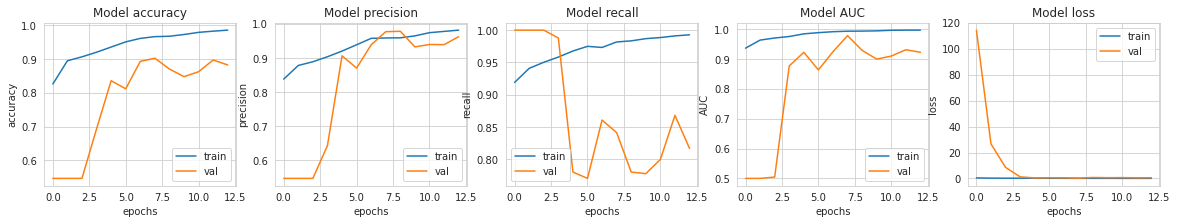

In [ ]:
# Evalute the models results and put into a dict
results = model_cnn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_cnn.metrics_names,results))

print(results)
plottingScores(history_cnn) # Visualise scores

## Mobile Net with Transfer Learning

In [ ]:
def build_mn_model():
    
    model = tf.keras.Sequential([
        tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(128, 128, 3)),
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.layers[0].trainable = False
    
    return model

In [ ]:
# Build and compile mobile net model
model_mn = build_mn_model()
model_mn.summary()
model_mn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_mn = model_mn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 30, 
                          validation_split = 0.20, 
                          class_weight = classWeight,
                          batch_size = 64,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler])

Epoch 1/30
63/63 [==============================] - 8s 64ms/step - loss: 0.1971 - accuracy: 0.9072 - precision: 0.9193 - recall: 0.9183 - AUC: 0.9715 - val_loss: 0.0805 - val_accuracy: 0.9770 - val_precision: 0.9799 - val_recall: 0.9781 - val_AUC: 0.9943 - lr: 0.0100
Epoch 2/30
63/63 [==============================] - 2s 37ms/step - loss: 0.0525 - accuracy: 0.9822 - precision: 0.9781 - recall: 0.9901 - AUC: 0.9968 - val_loss: 0.0696 - val_accuracy: 0.9840 - val_precision: 0.9784 - val_recall: 0.9927 - val_AUC: 0.9953 - lr: 0.0089
Epoch 3/30
63/63 [==============================] - 2s 37ms/step - loss: 0.0399 - accuracy: 0.9905 - precision: 0.9862 - recall: 0.9968 - AUC: 0.9977 - val_loss: 0.0614 - val_accuracy: 0.9870 - val_precision: 0.9837 - val_recall: 0.9927 - val_AUC: 0.9955 - lr: 0.0079
Epoch 4/30
63/63 [==============================] - 2s 36ms/step - loss: 0.0339 - accuracy: 0.9910 - precision: 0.9866 - recall: 0.9973 - AUC: 0.9984 - val_loss: 0.0580 - val_accuracy: 0.9890 - va

94/94 [==============================] - 1s 15ms/step - loss: 0.0501 - accuracy: 0.9847 - precision: 0.9864 - recall: 0.9852 - AUC: 0.9967
{'loss': 0.05010157451033592, 'accuracy': 0.984666645526886, 'precision': 0.9863861203193665, 'recall': 0.9851668477058411, 'AUC': 0.9967143535614014}


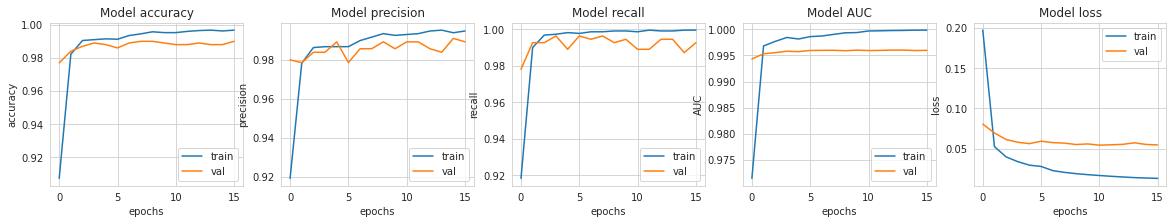

In [ ]:
# Show results and print graphs
results = model_mn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_mn.metrics_names,results))

print(results)
plottingScores(history_mn) # Visualise scores